# Image Compression with Singular Value Decomposition

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from skimage import data
from skimage.io import imread
import math

## Auxiliary functions

In [37]:
# function to plot relative error and compression
# factor for each iteration for a single-channel image

def plot_res(err_rel, c):
  plt.figure(figsize=(12, 4))

  fig1 = plt.subplot(1, 2, 1)
  fig1.plot(err_rel, 'o-')
  plt.title('Errore relativo')

  fig2 = plt.subplot(1, 2, 2)
  fig2.plot(c, 'o-')
  plt.title('Fattore di compressione')

  plt.show()

In [38]:
# function to plot relative error and compression
# factor for each iteration for a multi-channel image

def plot_res_coloured(err_rel, c):
  plt.figure(figsize=(12, 4))

  fig1 = plt.subplot(1, 2, 1)
  plt.title('Errore relativo')

  fig2 = plt.subplot(1, 2, 2)
  plt.title('Fattore di compressione')

  for i in range(3):
    fig1.plot(err_rel[i], '.-', label=f"Channel {i}")
    fig2.plot(c[i], '.-', label=f"Channel {i}")

  fig1.legend()
  fig2.legend()
  plt.show()

In [39]:
# function to display the compressed images obtained

def show_compressed(compressed, ps, cmap=None, columns=3):
  lines = math.ceil(len(compressed) / columns)
  fig, axs = plt.subplots(lines, columns, figsize=(columns*6, lines*6))

  for i in range(len(ps)):
    axs[int(i/columns), i%columns].imshow(compressed[i].astype('uint8'), cmap=cmap)
    axs[int(i/columns), i%columns].set_title(f'p = {ps[i]}')
  plt.show()

## Black and white image with little detail

### Function to perform image compression

In [40]:
'''
Function to compress single-channel image A using SVD.
It calculates the rank-p approximation for all possible ranks, and it saves the
reconstrcuted images corresponding to the ranks specified in ps.
'''

def compress(A, ps):
  p_max = np.min(A.shape) # max approximation rank = rank of A
  A_p = np.zeros(A.shape) # reconstructed image

  # logging arrays
  err_rel = np.zeros((p_max)) # relative error per iteration
  c = np.zeros((p_max)) # compression factor per iteration
  compressed = [] # images whose approximation rank is in ps

  # SVD
  U, s, Vh = scipy.linalg.svd(A)

  for i in range(p_max):
    ui = U[:, i]
    vi = Vh[i, :]

    # approximate matrix as a sum of dyads
    A_p += s[i] * np.outer(ui, vi)

    # relative error and compression factor
    err_rel[i] = np.linalg.norm(A - A_p, ord='fro') / np.linalg.norm(A, ord='fro')
    c[i] = (1 / (i+1)) * np.min(A.shape) - 1

    # save some images for plotting
    if i in ps:
        compressed.append(A_p.copy())

  return err_rel, c, compressed, A_p

### Image compression

<class 'numpy.ndarray'>
(512, 512)


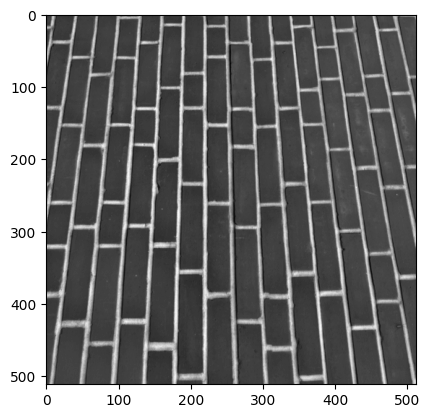

In [41]:
# load and show image
A = data.brick()

print(type(A))
print(A.shape)

plt.imshow(A, cmap='gray')
plt.show()

In [42]:
# SVD
U, s, Vh = scipy.linalg.svd(A)

print('Shape of U:', U.shape)
print('Shape of s:', s.shape)
print('Shape of V:', Vh.T.shape)

Shape of U: (512, 512)
Shape of s: (512,)
Shape of V: (512, 512)


In [43]:
ps = [10, 15, 20, 25, 30, 35, 40, 45]

err_rel, c, compressed, A_p = compress(A, ps)

### Results

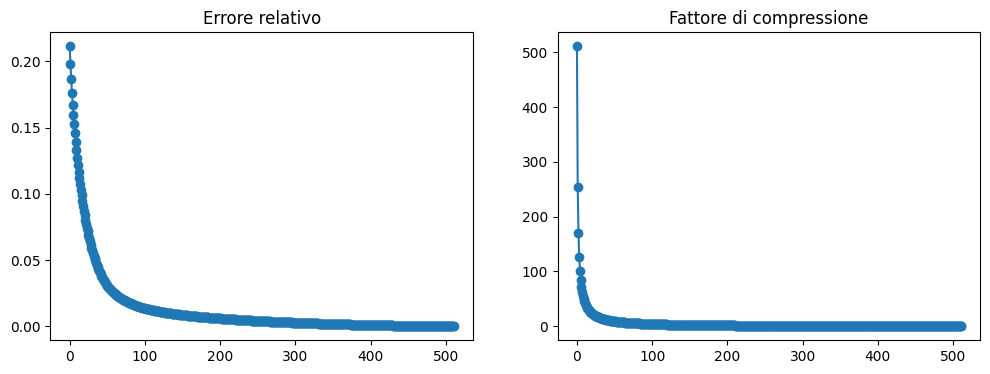

In [44]:
plot_res(err_rel, c)

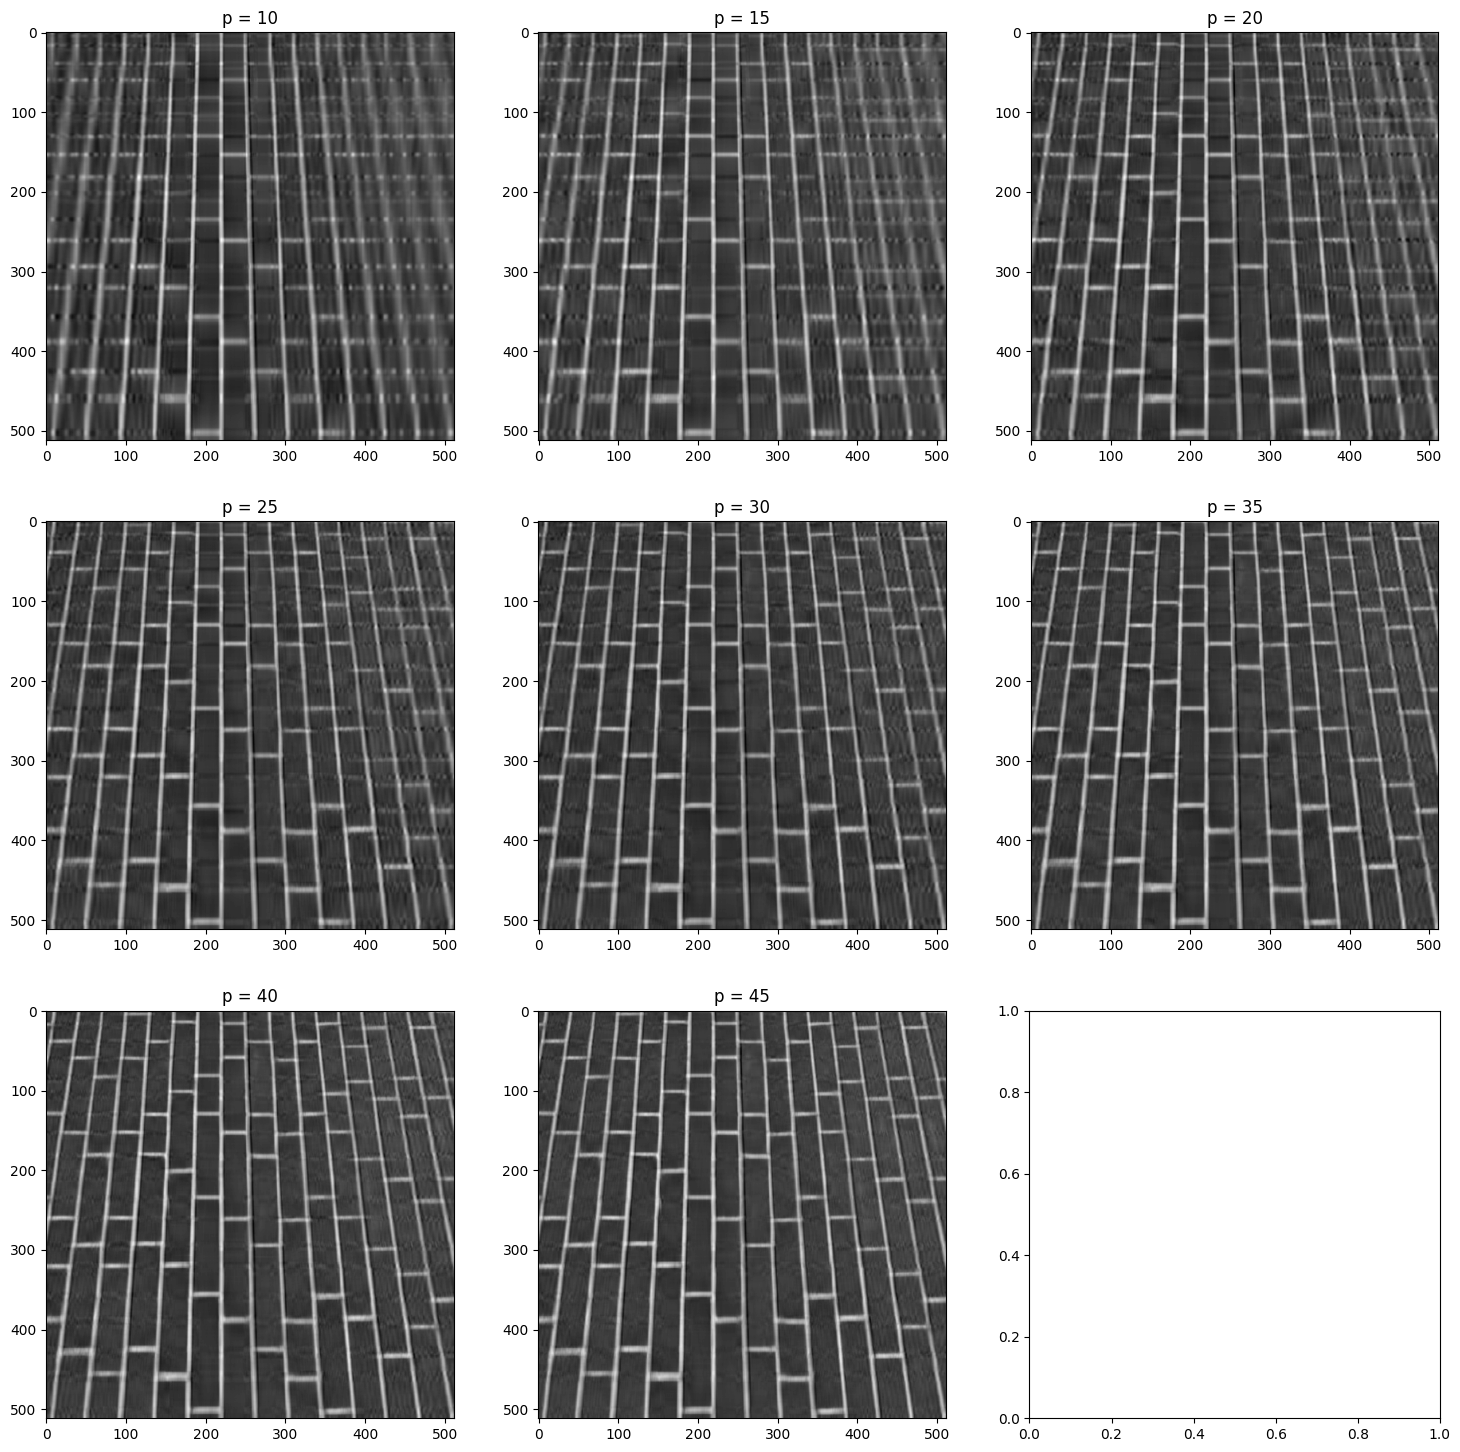

In [45]:
show_compressed(compressed, ps, cmap='gray')

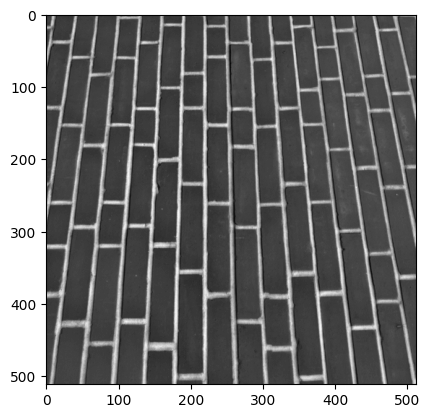

In [46]:
# check that highest rank reconstruction is "the same" as the original image
plt.imshow(A_p.astype('uint8'), cmap='gray')
plt.show()

## Coloured image with more details

### Function to perform image compression

In [47]:
'''
Function to compress multi-channel image A using SVD.
It calculates the rank-p approximation for all possible ranks, and it saves the
reconstrcuted images corresponding to the ranks specified in ps.
'''

def compress_coloured(A, ps):
  p_max = np.min(A.shape[:-1]) # max approximation rank = rank of A
  A_p = np.zeros(A.shape) # reconstructed image

  err_rel = [np.zeros((p_max)) for _ in range(A.shape[-1])] # relative error per iteration
  c = [np.zeros((p_max)) for _ in range(A.shape[-1])] # compression factor per iteration
  compressed = [] # images whose approximation rank is in ps

  # save SVD decompositions for each channel
  U, s, Vh = [], [], []
  for ch in range(A.shape[2]):
    U_ch, s_ch, Vh_ch = scipy.linalg.svd(A[:, :, ch])
    U.append(U_ch)
    s.append(s_ch)
    Vh.append(Vh_ch)

  # perform the compression for each channel
  for i in range(p_max):
    for ch in range(A.shape[2]):
      ui = U[ch][:, i]
      vi = Vh[ch][i, :]

      # approximate channel as a sum of dyads
      A_p[:, :, ch] += s[ch][i] * np.outer(ui, vi)

      # relative error and compression factor
      err_rel[ch][i] = np.linalg.norm(A[:, :, ch] - A_p[:, :, ch], ord='fro') / np.linalg.norm(A[:, :, ch], ord='fro')
      c[ch][i] = (1 / (i + 1)) * p_max - 1

    if i in ps:
      compressed.append(A_p.copy())

  return err_rel, c, compressed, A_p

### Image compression

<class 'numpy.ndarray'>
(512, 512, 3)


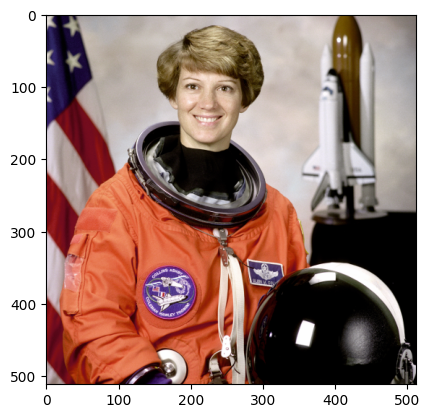

In [48]:
# load and show image
A = data.astronaut()

print(type(A))
print(A.shape)

plt.imshow(A, cmap='gray')
plt.show()

In [49]:
err_rel, c, compressed, A_p = compress_coloured(A, ps)

### Results

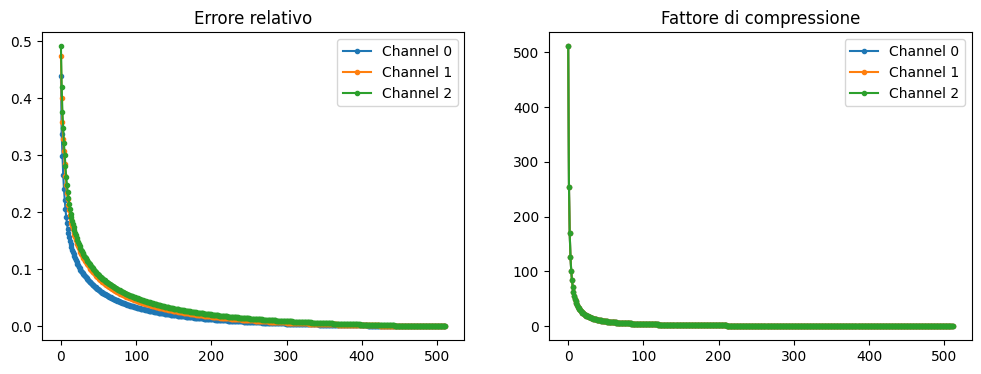

In [50]:
plot_res_coloured(err_rel, c)

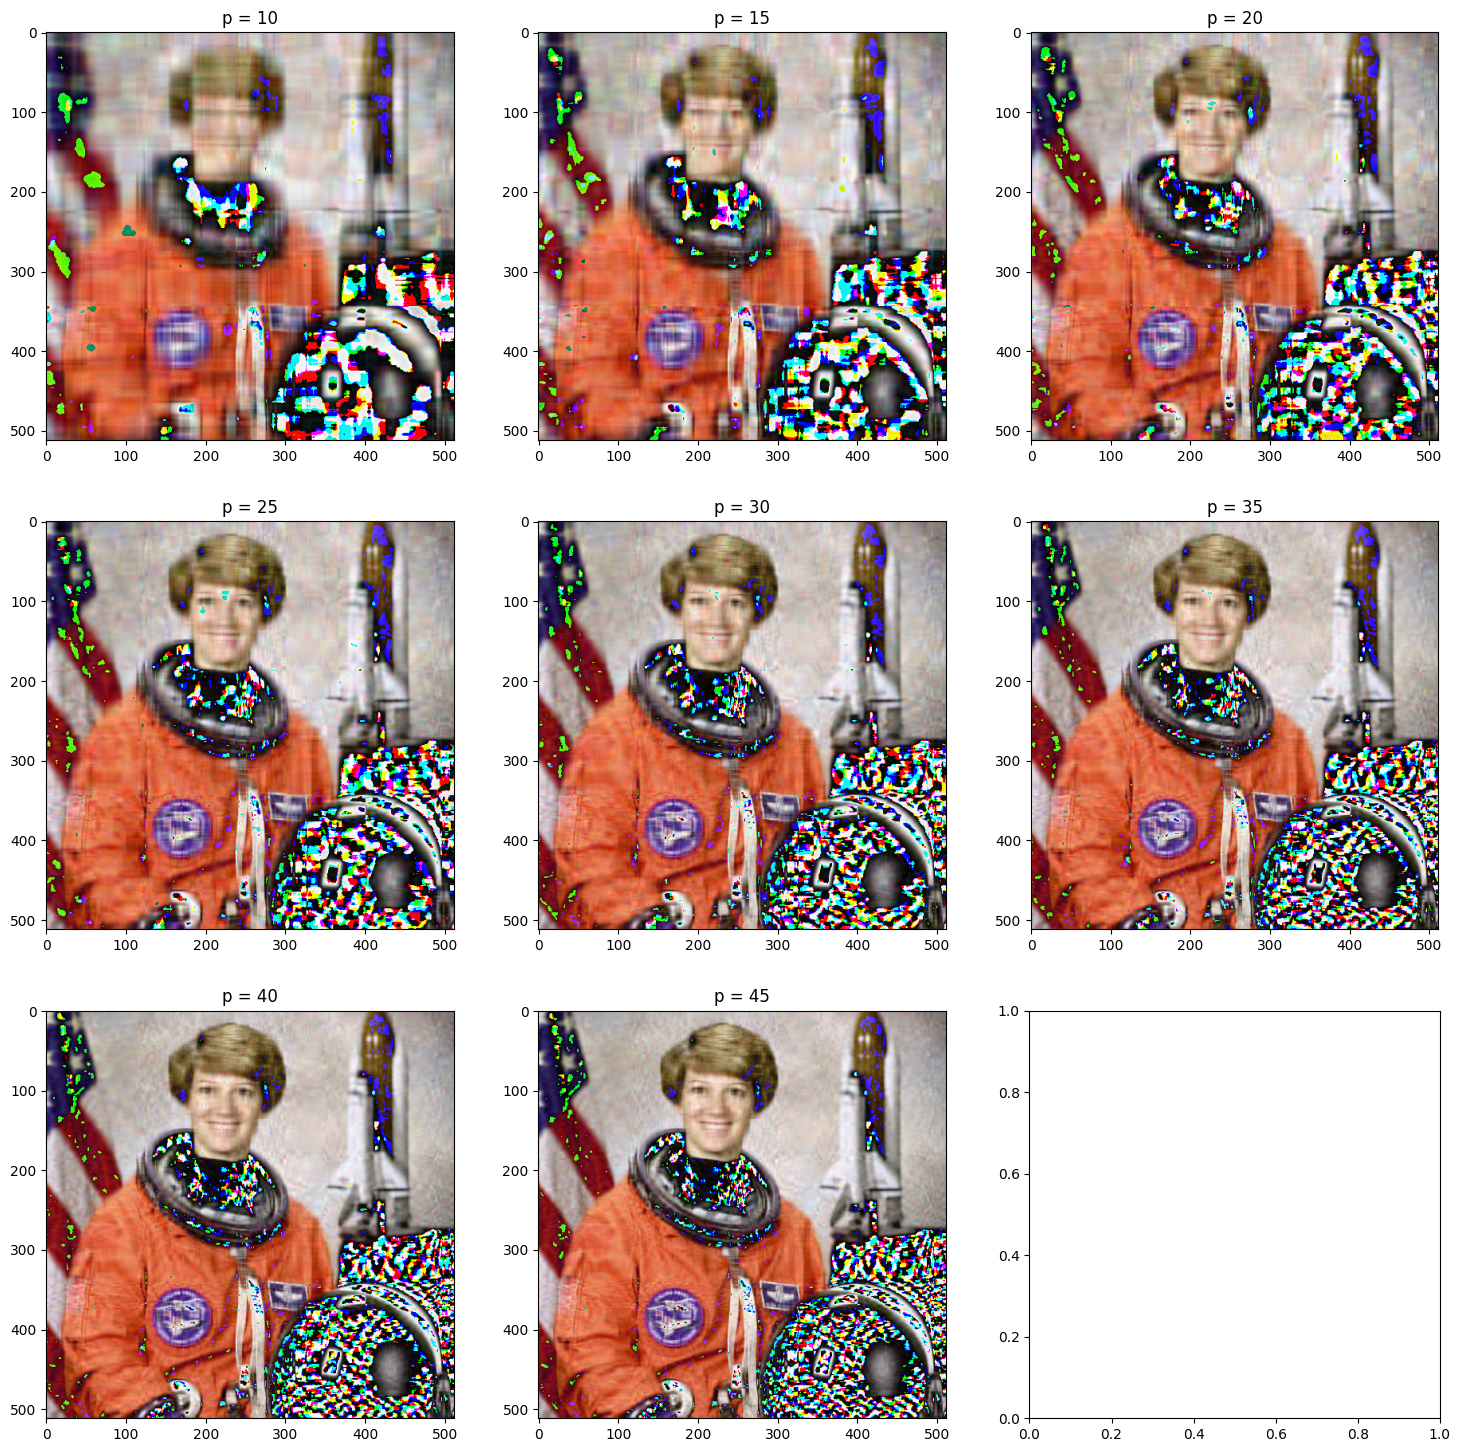

In [51]:
show_compressed(compressed, ps)

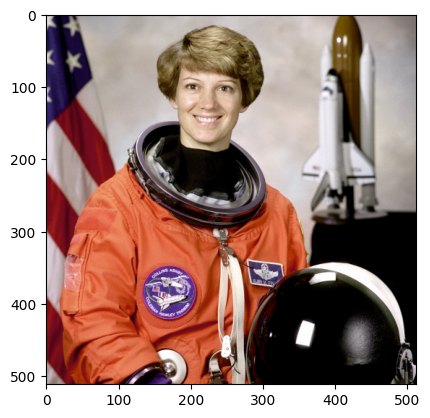

In [52]:
# check that highest rank reconstruction is "the same" as the original image
plt.imshow(A_p.astype('uint8'), cmap='gray')
plt.show()